<a href="https://colab.research.google.com/github/Simoni2412/Wrinkles-Detection/blob/main/Unet_CNN_for_wrinkles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mediapipe==0.10.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.1 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import hashlib

def file_hash(filepath):
    with open(filepath, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

def compare_folders(folder1, folder2):
    mismatches = []
    for filename in os.listdir(folder1):
        path1 = os.path.join(folder1, filename)
        path2 = os.path.join(folder2, filename)

        if not os.path.exists(path2):
            mismatches.append((filename, "Missing in folder2"))
            continue

        # if file_hash(path1) != file_hash(path2):
        #     mismatches.append((filename, "Different content"))

    return mismatches

# Example usage
folder1 = "/content/drive/MyDrive/Dataset /Original_image_Dataset"
folder2 = "/content/drive/MyDrive/Dataset /Wrinkles_Masks"
differences = compare_folders(folder1, folder2 )

if differences:
    for name, issue in differences:
        print(f"{name}: {issue}")
else:
    print("All images are identical.")

All images are identical.


In [3]:

import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2D, UpSampling2D, BatchNormalization, ReLU, Multiply, Input, GlobalAveragePooling2D, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, MaxPooling2D, Dropout, Add, ZeroPadding2D
from tensorflow.keras.layers import Concatenate as Concat
from google.colab.patches import cv2_imshow
from tensorflow.keras import layers, models
from PIL import Image
import os

In [4]:
from google.colab.patches import cv2_imshow
import os
from tqdm import tqdm

input_folder = "/content/drive/MyDrive/Dataset /Wrinkle_Annotated_Dataset"
output_folder = "/content/drive/MyDrive/Dataset /Wrinkles_Masks"

for filename in tqdm(os.listdir(input_folder)):
  if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
    img_path = os.path.join(input_folder, filename)
    image = cv2.imread(img_path)

    # if os.path.exists(mask_path):
    #         continue

    lower_red = np.array([0,0,180]) # color used for annotating wrinkle -> red
    upper_red = np.array([80,80,255]) # broader range for flexibility -> borader range of red


    mask = cv2.inRange(image, lower_red, upper_red)

    mask_path = os.path.join(output_folder, f"{filename}")
    #cv2.imwrite(mask_path, mask)

  3%|▎         | 3/99 [00:06<03:34,  2.23s/it]


KeyboardInterrupt: 

In [5]:
base_path = "/content/drive/MyDrive/Dataset /"
mask_path = base_path + "Wrinkles_Masks/"
image_path = base_path + "Original_image_Dataset/"
# ground_truth = base_path + "Ground_Truth/"
# spare_gt = base_path + "GT/"
val_image_path = base_path + "Val_images/"
val_mask_path = base_path + "Val_mask/"

print(f"Checking mask_path: {mask_path}")
if not os.path.isdir(mask_path):
    print(f"Error: {mask_path} is not a directory. Please check the variable assignment.")
    # You might want to exit or handle this error more gracefully
else:
    print(f"{mask_path} is a valid directory.")


Checking mask_path: /content/drive/MyDrive/Dataset /Wrinkles_Masks/
/content/drive/MyDrive/Dataset /Wrinkles_Masks/ is a valid directory.


In [6]:

# def image_processing(image_path):
#     try:
#         image = Image.open(image_path).convert('RGB')
#     except Image.DecompressionBombError:
#         print("Image is too large, trying to open with limited size...")
#         Image.MAX_IMAGE_PIXELS = None
#         image = Image.open(image_path).convert('RGB')
#     max_width = 256
#     max_height = 256
#     image.thumbnail((max_width, max_height), Image.LANCZOS)
#     image = np.array(image)  # Now a NumPy array, shape (H, W, 3)
#     return image

In [9]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 41.9 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [11]:
IMG_SIZE = (256, 256)

def preprocess_image(image_path, mask_path, n_classes=1):
    # Read image
    image = cv2.imread(image_path.numpy().decode('utf-8'))
   # --- Added check ---
    if image is None:
        print(f"Error: Could not read image file at path: {image_path}")
        # Return default values or handle the error as needed
        # For now, returning zero tensors to allow the dataset to build,
        # but the root cause needs to be investigated.
        return np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.float32), np.zeros((IMG_SIZE[0], IMG_SIZE[1], 1), dtype=np.float32 if n_classes==1 else np.uint8)
    # --- End added check ---

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Enhancement (CLAHE + bilateral)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    #filtered = cv2.bilateralFilter(enhanced, 9, 75, 75)
    normalized = enhanced.astype(np.float32) / 255.0

    # Convert to 3 channels
    image = np.stack([normalized]*3, axis=-1)
    #image = np.stack([filtered]*3, axis=-1)
    image = cv2.resize(image, IMG_SIZE)

    # Read mask
    mask = cv2.imread(mask_path.numpy().decode('utf-8'), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, IMG_SIZE, interpolation=cv2.INTER_NEAREST)
    if n_classes == 1:
        mask = (mask > 127).astype(np.float32)
        mask = mask[..., None]
    else:
        # For multiclass, ensure mask values are 0, 1, 2, ...
        mask = mask.astype(np.uint8)
        mask = mask[..., None]
    return image, mask

def tf_preprocess_image(image_path, mask_path, n_classes=1):
    image, mask = tf.py_function(
        func=preprocess_image,
        inp=[image_path, mask_path, n_classes],
        Tout=[tf.float32, tf.float32 if n_classes==1 else tf.uint8]
    )
    image.set_shape([IMG_SIZE[0], IMG_SIZE[1], 3])
    mask.set_shape([IMG_SIZE[0], IMG_SIZE[1], 1])
    return image, mask

def get_dataset(image_dir, mask_dir, batch_size=8, augment=False):
    image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
    mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])
    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
    dataset = dataset.map(lambda x, y: tf_preprocess_image(x, y, n_classes), num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        dataset = dataset.map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


import tensorflow as tf
#import tensorflow_addons as tfa
import numpy as np # Needed for np.pi if calculating radians from degrees

def augment_fn(image, mask):
    # Ensure image and mask have consistent random transformations

    # 1. Random Flip (Horizontal) - applied to both
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # 2. Random Rotation (up to 5% = 0.05 radians = approx 2.86 degrees) - applied to both
    # Use tfa.image.rotate for small arbitrary angles
    # The angle is in radians. 5% rotation is often interpreted as 0.05 radians.
    # max_angle_rad = 0.05
    # angle = tf.random.uniform((), minval=-max_angle_rad, maxval=max_angle_rad)
    # # Rotate image using bilinear interpolation
    # image = tfa.image.rotate(image, angle, interpolation='BILINEAR')
    # # Rotate mask using nearest neighbor interpolation to preserve labels
    # mask = tfa.image.rotate(mask, angle, interpolation='NEAREST')


    # 3. Random Zoom (up to 10%) - applied to both
    # A simple way to simulate zoom-in is random cropping and resizing back.
    # Zoom factor Z means cropping by 1/Z. Zooming up to 10% means Z up to 1.1
    # Corresponding crop factor C = 1/Z from ~0.9 to 1.0
    # We will crop a patch between 90% and 100% of the original size and resize.
    img_shape = tf.shape(image)
    h = img_shape[0]
    w = img_shape[1]

    # Random scale factor between 0.9 and 1.0 (1.0 means no zoom-in/no crop)
    scale = tf.random.uniform((), minval=0.9, maxval=1.0)
    new_h = tf.cast(scale * tf.cast(h, tf.float32), tf.int32)
    new_w = tf.cast(scale * tf.cast(w, tf.float32), tf.int32)

    # Ensure crop size is at least 1x1
    new_h = tf.maximum(1, new_h)
    new_w = tf.maximum(1, new_w)

    # Random crop
    stacked_img_mask = tf.concat([image, mask], axis=-1) # Stack image and mask
    cropped_stacked = tf.image.random_crop(stacked_img_mask, size=[new_h, new_w, tf.shape(stacked_img_mask)[-1]])

    # Resize back to original size
    resized_stacked = tf.image.resize(
        cropped_stacked,
        size=[h, w],
        method=tf.image.ResizeMethod.BILINEAR # Use BILINEAR for combined tensor
    )

    # Separate image and mask again
    image = resized_stacked[..., :3]
    mask = resized_stacked[..., 3:]

    # For mask after resize, you might need to re-threshold or cast back to int if not using one-hot encoding
    # If your mask is one-hot, BILINEAR resize is okay. If it's integer labels, NEAREST is better.
    # Assuming one-hot or float mask from previous steps, BILINEAR is often acceptable for resize after crop.
    # If your mask is integer labels (0, 1, 2), you should resize using NEAREST method:
    # resized_stacked = tf.image.resize( ..., method=tf.image.ResizeMethod.NEAREST)
    # Let's assume your mask is float/one-hot compatible for now.

    # 4. Random Contrast (up to 2% = factor range [0.98, 1.02]) - applied only to image
    # max_delta = 0.02 means factor range [1-0.02, 1+0.02] = [0.98, 1.02]
    image = tf.image.random_contrast(image, lower=0.98, upper=1.02)


    # Ensure data types and shapes are consistent after augmentations
    # Get the original number of mask channels before concat
    original_mask_channels = tf.shape(mask)[-1] # This might need careful handling depending on exact mask dtype/shape

    # Use ensure_shape if you know the fixed spatial size, or rely on dynamic shapes
    image.set_shape([IMG_SIZE[0], IMG_SIZE[1], 3]) # Assuming IMG_SIZE is defined
    mask.set_shape([IMG_SIZE[0], IMG_SIZE[1], tf.shape(mask)[-1]]) # Keep mask channels dynamic


    return image, mask

In [18]:
pip show tensorflow

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras


In [12]:
from typing import Concatenate
class GaussianFilterLayer(Layer):
    def __init__(self, **kwargs):
        super(GaussianFilterLayer, self).__init__(**kwargs)

    def call(self, x):
        gaussian_kernel = tf.constant([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype=tf.float32)
        gaussian_kernel = gaussian_kernel[:, :, None, None] / 16  # Normalized kernel
        gaussian_kernel = tf.repeat(gaussian_kernel, repeats=x.shape[-1], axis=-1)
        return tf.nn.conv2d(x, filters=tf.cast(gaussian_kernel, tf.float32), strides=[1,1,1,1], padding="SAME")

def channel_avg(x):
    return tf.reduce_mean(x, axis=-1, keepdims=True)

def channel_max(x):
    return tf.reduce_max(x, axis=-1, keepdims=True)

def spatial_attention(x):
    avg_pool =  layers.Lambda(channel_avg)(x)
    max_pool = layers.Lambda(channel_max)(x)
    #max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    sa = layers.Conv2D(1, 7, padding='same', activation='sigmoid')(concat)
    return layers.Multiply()([x, sa])

# def channel_attention(x):
#     """ Channel Attention Module for refinement """
#     avg_pool = GlobalAveragePooling2D()(x)
#     dense1 = Dense(x.shape[-1] // 2, activation="relu")(avg_pool)
#     dense2 = Dense(x.shape[-1], activation="sigmoid")(dense1)
#     dense2 = tf.keras.layers.Reshape((1, 1, x.shape[-1]))(dense2)  # Ensure correct shape
#     return Multiply()([x, dense2])

# ---- Attention Module ----
def attention_block(x, g, inter_channels):
    theta_x = Conv2D(inter_channels, (1,1), padding="same")(x)
    phi_g = Conv2D(inter_channels, (1,1), padding="same")(g)
    add_xg = Add()([theta_x, phi_g])
    act_xg = Activation('relu')(add_xg)
    psi = Conv2D(1, (1,1), padding="same", activation="sigmoid")(act_xg)
    return Multiply()([x, psi])

def conv_block(x, filters):
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def wrinkle_segmentation_model(input_shape):
    """ Define U-Net with Spatial & Channel Attention """
    inputs = Input(shape=input_shape)
    # Encoder
    conv1 = conv_block(inputs, 32)
    pool1 = MaxPooling2D()(conv1)

    conv2 = conv_block(pool1, 64)
    pool2 = MaxPooling2D()(conv2)

    conv3 = conv_block(pool2, 128)
    pool3 = MaxPooling2D()(conv3)

    conv4 = conv_block(pool3, 256)
    pool4 = MaxPooling2D()(conv4)

    # Bottleneck
    bneck = conv_block(pool4, 512)
    bn = spatial_attention(bneck)

    # Decoder
    up4 = UpSampling2D()(bn)
    attn4 = attention_block(conv4, up4, 256)
    merge4 = Concat()([up4, attn4])
    conv5 = conv_block(merge4, 256)

    up3 = UpSampling2D()(conv5)
    attn3 = attention_block(conv3, up3, 128)
    merge3 = Concat()([up3, attn3])
    conv6 = conv_block(merge3, 128)

    up2 = UpSampling2D()(conv6)
    attn2 = attention_block(conv2, up2, 64)
    merge2 = Concat()([up2, attn2])
    conv7 = conv_block(merge2, 64)

    up1 = UpSampling2D()(conv7)
    attn1 = attention_block(conv1, up1, 32)
    merge1 = Concat()([up1, attn1])
    conv8 = conv_block(merge1, 32)

    # Output layer

    output_layer = Conv2D(1, 1, activation="sigmoid", padding="same")(conv8)


    model = Model(inputs, output_layer)
    return model

def wrinkle_scoring(wrinkle_mask):
    """ Calculate wrinkle score using weighted contrast analysis """
    score = np.sum(wrinkle_mask) / (wrinkle_mask.shape[0] * wrinkle_mask.shape[1])
    return np.clip(score * 100, 0, 100)  # Normalize score

def predict_age(wrinkle_score):

    """ Map wrinkle score to estimated age range """
    if wrinkle_score < 20:
        return "20-30 years"
    elif wrinkle_score < 40:
        return "30-40 years"
    elif wrinkle_score < 60:
        return "40-50 years"
    else:
        return "50+ years"

In [9]:


def additive_attention_module(encoder_feat, decoder_feat, filters):
    # Upsample decoder feature to match encoder spatial size
    up_dec = layers.UpSampling2D()(decoder_feat)
    up_dec = layers.Conv2D(filters, 3, padding='same')(up_dec)
    up_dec = layers.BatchNormalization()(up_dec)
    up_dec = layers.Activation('relu')(up_dec)

    # 1x1 convs for encoder and decoder features
    theta_x = layers.Conv2D(filters, 1, padding='same')(encoder_feat)
    phi_g = layers.Conv2D(filters, 1, padding='same')(up_dec)

    # Add and activate
    add = layers.Add()([theta_x, phi_g])
    act = layers.Activation('relu')(add)
    psi = layers.Conv2D(1, 1, padding='same')(act)
    psi = layers.Activation('sigmoid')(psi)

    # Multiply attention map with encoder features
    attn_out = layers.Multiply()([encoder_feat, psi])

    # Concatenate with upsampled decoder features
    out = layers.Concatenate()([up_dec, attn_out])
    return out

# def spatial_attention(x):
#     avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(x)
#     max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(x)
#     #max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
#     concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
#     sa = layers.Conv2D(1, 7, padding='same', activation='sigmoid')(concat)
#     return layers.Multiply()([x, sa])

# def conv_block(x, filters):
#     x = layers.Conv2D(filters, 3, padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = layers.Conv2D(filters, 3, padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     return x

def attention_unet_paper(input_shape=(256,256,3), n_classes=1, padding=32):
    inputs = layers.Input(input_shape)
    # Zero-padding
    x = layers.ZeroPadding2D(padding=padding)(inputs)

    # Encoder
    c1 = conv_block(x, 32)
    p1 = layers.MaxPooling2D()(c1)
    c2 = conv_block(p1, 64)
    p2 = layers.MaxPooling2D()(c2)
    c3 = conv_block(p2, 128)
    p3 = layers.MaxPooling2D()(c3)
    c4 = conv_block(p3, 256)
    p4 = layers.MaxPooling2D()(c4)

    # Bottleneck + spatial attention
    bn = conv_block(p4, 512)
    bn = spatial_attention(bn)

    # Decoder with AAM
    d4 = additive_attention_module(c4, bn, 256)
    d4 = conv_block(d4, 256)
    d3 = additive_attention_module(c3, d4, 128)
    d3 = conv_block(d3, 128)
    d2 = additive_attention_module(c2, d3, 64)
    d2 = conv_block(d2, 64)
    d1 = additive_attention_module(c1, d2, 32)
    d1 = conv_block(d1, 32)

#Output
    if n_classes == 1:
        outputs = layers.Conv2D(1, 1, activation='sigmoid')(d1)
    else:
        outputs = layers.Conv2D(n_classes, 1, activation='softmax')(d1)
    return models.Model(inputs, outputs)
    # return models.Model(inputs, outputs)

# def attention_unet(input_shape=(256,256,3), n_classes=1):
#     inputs = layers.Input(input_shape)
#     # Encoder
#     c1 = conv_block(inputs, 32)
#     p1 = layers.MaxPooling2D()(c1)
#     c2 = conv_block(p1, 64)
#     p2 = layers.MaxPooling2D()(c2)
#     c3 = conv_block(p2, 128)
#     p3 = layers.MaxPooling2D()(c3)
#     c4 = conv_block(p3, 256)
#     p4 = layers.MaxPooling2D()(c4)
#     # Bottleneck
#     bn = conv_block(p4, 512)
#     # Decoder with attention
#     u4 = layers.UpSampling2D()(bn)
#     att4 = attention_gate(c4, u4, 256)
#     u4 = layers.Concatenate()([u4, att4])
#     c5 = conv_block(u4, 256)
#     u3 = layers.UpSampling2D()(c5)
#     att3 = attention_gate(c3, u3, 128)
#     u3 = layers.Concatenate()([u3, att3])
#     c6 = conv_block(u3, 128)
#     u2 = layers.UpSampling2D()(c6)
#     att2 = attention_gate(c2, u2, 64)
#     u2 = layers.Concatenate()([u2, att2])
#     c7 = conv_block(u2, 64)
#     u1 = layers.UpSampling2D()(c7)
#     att1 = attention_gate(c1, u1, 32)
#     u1 = layers.Concatenate()([u1, att1])
#     c8 = conv_block(u1, 32)
#     # Output
#     if n_classes == 1:
#         outputs = layers.Conv2D(1, 1, activation='sigmoid')(c8)
#     else:
#         outputs = layers.Conv2D(n_classes, 1, activation='softmax')(c8)
#     return models.Model(inputs, outputs)
model = attention_unet_paper(input_shape=(256,256,3), n_classes=2, padding=32)

In [13]:
import tensorflow as tf

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# def focal_loss(y_true, y_pred, alpha=0.8, gamma=2):
#     bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
#     bce_exp = tf.exp(-bce)
#     focal = alpha * (1 - bce_exp) ** gamma * bce
#     return focal

def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    # focal = focal_loss(y_true, y_pred)
    dsc = dice_loss(y_true, y_pred)
    return bce + dsc

In [14]:

# ... (rest of your code) ...

# Define early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)  # Adjust patience as needed

n_classes = 1
train_dataset = get_dataset(image_path, mask_path, batch_size=5, augment=False)
val_dataset = get_dataset(val_image_path, val_mask_path, batch_size=5, augment=False)

#model = attention_unet_paper(input_shape=(256,256,3), padding=0)
model = wrinkle_segmentation_model(input_shape=(256,256,3))
#model.compile(optimizer='adam', loss=combined_loss, metrics=['accuracy'])
# # Define the MSE loss
# mse_loss = tf.keras.losses.MeanSquaredError()

# # Compile the model using MSE
# model.compile(optimizer='adam', loss=mse_loss, metrics=['accuracy'])


# Train
model.fit(train_dataset,validation_data=val_dataset, epochs=50, callbacks=[early_stop])


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 182s 7s/step - accuracy: 0.8165 - loss: 0.1653 - val_accuracy: 0.0815 - val_loss: 0.8259
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 50s 753ms/step - accuracy: 0.9904 - loss: 0.0415 - val_accuracy: 0.3496 - val_loss: 0.6410
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 782ms/step - accuracy: 0.9896 - loss: 0.0320 - val_accuracy: 0.7446 - val_loss: 0.3289
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 792ms/step - accuracy: 0.9931 - loss: 0.0222 - val_accuracy: 0.9930 - val_loss: 0.0982
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 752ms/step - accuracy: 0.9939 - loss: 0.0172 - val_accuracy: 0.9945 - val_loss: 0.0661
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 764ms/step - accuracy: 0.9942 - loss: 0.0144 - val_accuracy: 0.9945 - val_loss: 0.0458
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 760ms/step - accuracy: 0.9943 - loss: 0.0126 - val_accuracy: 0.9945 - val_loss: 0.0327
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 764ms/step - accuracy: 0.9940 - loss: 0.0119 - val_accura

In [22]:
model.save('model_batch5_noaugment.h5')

In [15]:
for images, masks in train_dataset.take(1):
    preds = model.predict(images)
    break  # Only take the first batch


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [16]:
print("Prediction min:", preds.min(), "max:", preds.max(), "mean:", preds.mean())

Prediction min: 7.1332174e-10 max: 0.68938637 mean: 0.021330178


In [17]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# def combined_loss(y_true, y_pred):
#     bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
#     dsc = dice_loss(y_true, y_pred)
#     return bce + dsc

In [18]:
dice_loss = dice_loss(masks, preds)
print("Dice loss:", dice_loss.numpy())

Dice loss: 0.97159535


In [19]:
import matplotlib.pyplot as plt
import numpy as np

def display_sample(image, mask, pred):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(pred.squeeze(), cmap='gray')
    plt.title('Prediction')
    plt.axis('off')
    plt.show()

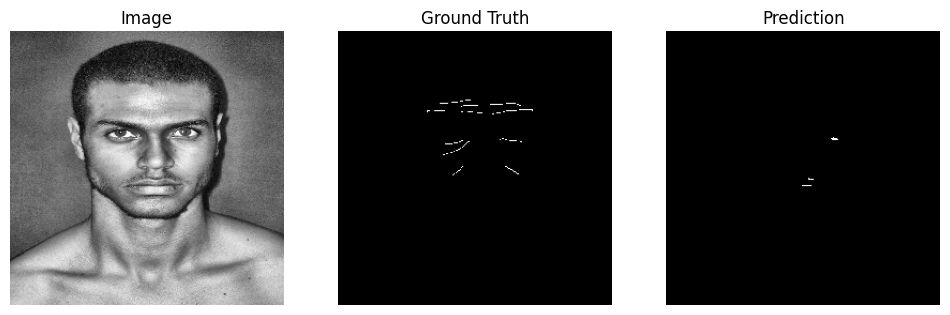

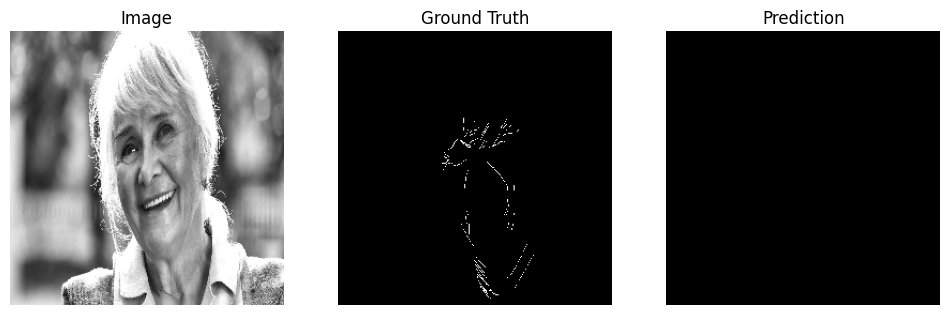

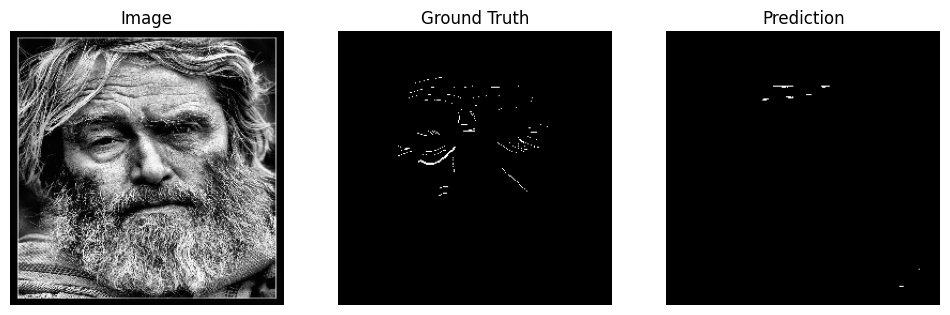

In [21]:
for i in range(min(3, images.shape[0])):  # Show up to 3 samples
    display_sample(
        images[i].numpy(),
        masks[i].numpy(),
        (preds[i] > 0.2).astype(np.float32)  # Threshold sigmoid output
    )

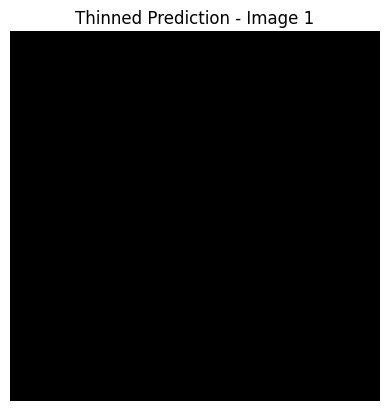

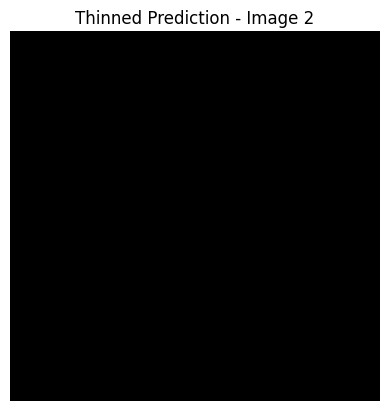

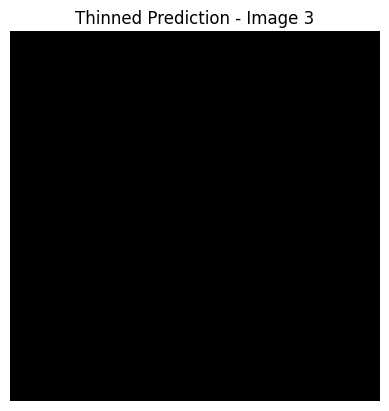

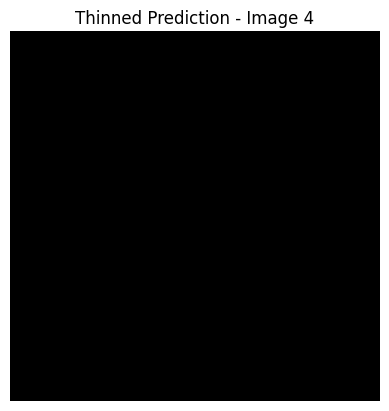

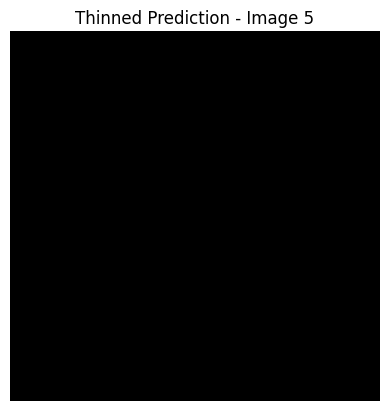

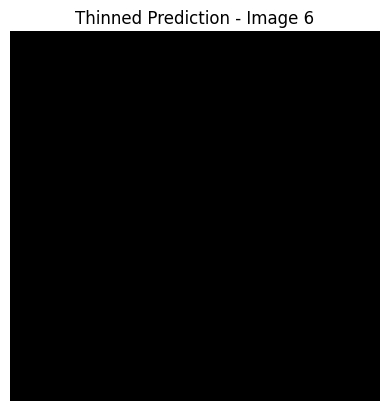

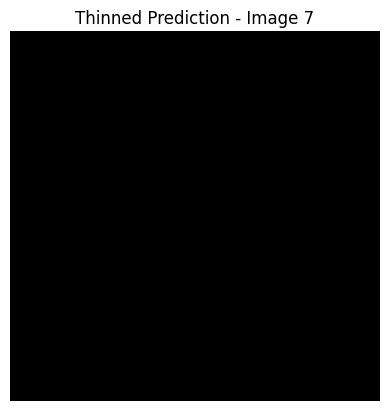

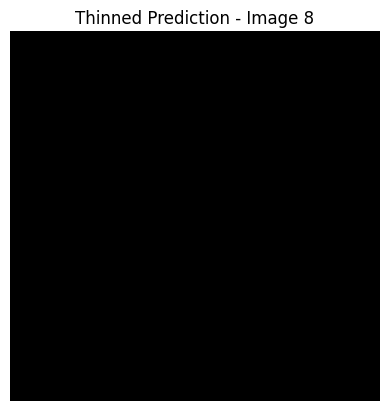

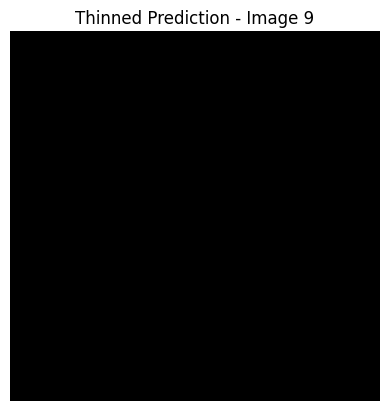

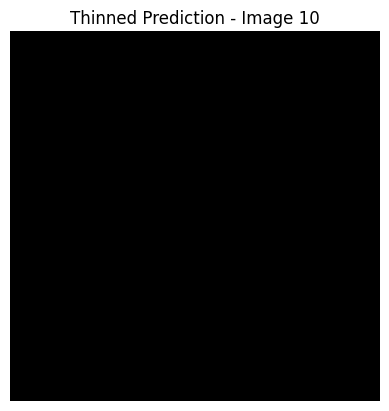

In [22]:
from skimage.morphology import skeletonize
def thined_prediction(preds):
    # Iterate through each image in the batch
# Iterate through each image in the batch
  for i in range(preds.shape[0]):
    thin_mask = skeletonize(preds[i].squeeze() > 0.9)  # Process each image individually
    plt.imshow(thin_mask, cmap='gray')
    plt.title(f'Thinned Prediction - Image {i + 1}')
    plt.axis('off')
    plt.show()
thinned = thined_prediction(preds)
thinned

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Dataset /Original/00420.png')
#img = image_processing(img_path)
#img = preprocess_image(img)
img = cv2.resize(img, (256, 256))
#img = img.astype(np.float32) / 255.0
#img = np.expand_dims(img, axis=0)
input_batch = np.expand_dims(img, axis=0)
pred = model.predict(input_batch)
thinned = thined_prediction(pred)
#plt.imshow(thinned, cmap='gray')
plt.show()

error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'
